# Compute trajectories

Compute molecular dynamics for Hinge WT and Hinge with insertion from 0 to at least 30 millions cycles, the steps will be:
- set-up
- minimize the energy of the system
- heat the system
- compute the molecular dynamics from 0 to 1 millions of cycles
- compute the molecular dynamics from 1 to 10 millions of cycles
- compute the molecular dynamics from 10 to 20 millions of cycles
- compute the molecular dynamics from 20 to 30 millions of cycles

## Set-up

We use `<ID>` as the file name of the protein.

With PyMol remove hydrogens produced by Alphafold2: `action/hydrogen/remove` and save it as `<ID>_no-hydrogen.pdb`

`LEaP` to produce coordinates (`.crd`), parameter (`.parm`) and `SANDER` PDB input files: 
```bash
# run LEaP
$AMBERHOME/bin/tleap

# Load force field
source leaprc.protein.ff14SB

# implicit solvant
mol = loadpdb leap/<ID>_no-hydrogen.pdb

# coordinates and topology
saveamberparm mol leap/<ID>.parm <ID>.crd

# pdb file
savepdb mol leap/<ID>_amber.pdb

quit
```

## Energy minimization

System initialisation in implicit solant:
```bash
$AMBERHOME/bin/sander -O -i ../config_MD_sander/config_sander_initial.in -p leap/<ID>.parm -c leap/<ID>.crd -o sander/<ID>_initial.out -r sander/<ID>_initialized.rst7 &
```

### System heating

```bash
$AMBERHOME/bin/sander -O -i ../config_MD_sander/config_sander_heating.in -p leap/<ID>.parm -c sander/<ID>_initialized.rst7 -o sander/<ID>_heating.out -r sander/<ID>_heated.rst7 &
```

### Molecular Dynamics

`sander` commands:
```bash
# MD 1 million of cycles
$AMBERHOME/bin/sander -O -i ../config_MD_sander/config_sander_MD-1M.in -p leap/<ID>.parm -c sander/<ID>_heated.rst7 -o sander/<ID>_MD-1M.out -r sander/<ID>_MD-1M.rst7 -x sander/<ID>_MD-1M.nc &

# MD 10 million of cycles
$AMBERHOME/bin/sander -O -i ../config_MD_sander/config_sander_MD-10M.in -p leap/<ID>.parm -c sander/<ID>_MD-1M.rst7 -o sander/<ID>_MD-10M.out -r sander/<ID>_MD-10M.rst7 -x sander/<ID>_MD-10M.nc &

# MD 20 million cycles
$AMBERHOME/bin/sander -O -i ../config_MD_sander/config_sander_MD-20M.in -p leap/<ID>.parm -c sander/<ID>_MD-10M.rst7 -o sander/<ID>_MD-20M.out -r sander/<ID>_MD-20M.rst7 -x sander/<ID>_MD-20M.nc &

# MD 30 million cycles
$AMBERHOME/bin/sander -O -i ../config_MD_sander/config_sander_MD-30M.in -p leap/<ID>.parm -c sander/<ID>_MD-20M.rst7 -o sander/<ID>_MD-30M.out -r sander/<ID>_MD-30M.rst7 -x sander/<ID>_MD-30M.nc &
```

But if the computation is launched on the CalMiP cluster, the sbatch script, for i.e. a molecular dynamics on 20 millions of cycles starting fom the previous step at 10 millions cycles, is:
```bash
#!/bin/bash

#SBATCH -J hinge_ins-RPS17_MD-20M
#SBATCH -N 1
#SBATCH -n 20
#SBATCH --ntasks-per-node=20
#SBATCH --ntasks-per-core=1
#SBATCH --mail-user=jeanne.n@chu-toulouse.fr
#SBATCH --mail-type=ALL

# variables analyse
PREVIOUS_ANALYSIS_ID=MD-10M
ANALYSIS_ID=MD-20M
SAMPLE=<ID>
DIR_TMP_RES=/tmpdir/jeanne/$ANALYSIS_ID
CONFIG_DIR=/tmpdir/jeanne/config_MD_sander

# Variables d'environnement
echo $AMBERHOME

# Chargement des modules necessaires a l'execution du script (et uniquement ces modules)
module purge
module load amber/amber16-ompi
ulimit -s 10240

source $AMBERSH

# Creation du dossier de résultats temporaires
mkdir -p $DIR_TMP_RES

# Nombre process MPI par calcul AMBER
export NMPI=16

cd $DIR_TMP_RES

srun ${placement} $AMBERHOME/bin/sander.MPI -O -i $CONFIG_DIR/config_sander_$ANALYSIS_ID".in" -p $DIR_TMP_RES/leap/$SAMPLE".parm" -c $DIR_TMP_RES/sander/$SAMPLE"_"$PREVIOUS_ANALYSIS_ID".rst7" -o $DIR_TMP_RES/sander/$SAMPLE"_"$ANALYSIS_ID".out" -r $DIR_TMP_RES/sander/$SAMPLE"_"$ANALYSIS_ID".rst7" -x $DIR_TMP_RES/sander/$SAMPLE"_"$ANALYSIS_ID".nc" &

wait

# récupération des données
cp $DIR_TMP_RES/sander/$SAMPLE"_"$ANALYSIS_ID"*" /gpfs/work/p1237/jeanne/molecular_dynamics/hinge/insertion_RPS17/sander
```

### Root Mean Square Deviation for trajectory analysis from the beginning

```bash
$AMBERHOME/bin/cpptraj.OMP

# load the parameter file
parm leap/<ID>.parm

# load the reference used as starting point
reference sander/<ID>_heated.rst7

# load the trajectories to analyse
trajin sander/<ID>_MD-1M.nc
trajin sander/<ID>_MD-10M.nc
trajin sander/<ID>_MD-20M.nc
trajin sander/<ID>_MD-30M.nc

# set computation of the RMSD
rms fromRef :1-73&@CA,C,O,N,H reference out cpptraj/RMSD_<ID>_MD_0_to_30M.agr mass

# run the analysis
go
```

Visualisation of the RMSD with `grace`:
```bash
# usual output
gracebat -printfile RMSD_<ID>_MD_0_to_30M.plot RMSD_<ID>_MD_0_to_30M.agr

# png output
gracebat -hdevice PNG -hardcopy -printfile RMSD_<ID>_MD-0_to_30M.png RMSD_<ID>_MD-0_to_30M.agr
```

### Merge the trajectories

Get the trajectories as one file for `<ID>`:
```bash
$AMBERHOME/bin/cpptraj.OMP

# load the parameter file
parm leap/<ID>.parm

# load the reference used as starting point
reference sander/<ID>_heated.rst7

# load the trajectories to analyse
trajin sander/<ID>_MD-1M.nc
trajin sander/<ID>_MD-10M.nc
trajin sander/<ID>_MD-20M.nc
trajin sander/<ID>_MD-30M.nc

# merge the trajectories
trajout trajectory_0_to_30M/<ID>_MD_0_to_30M.nc

# run the merging
go
```

# Trajectories analysis

The analysis is performed with the [trajectories.py](https://github.com/njeanne/molecular_dynamics_trajectories/tree/main) script.

Using a [mask selection](https://amber-md.github.io/pytraj/latest/atom_mask_selection.html) for the atoms of the contacts get the evolution of this contacts from the beginning to the end of the trajectory simulation.

The atoms contacts considered are:
- atoms contacts within 3 Angstroms distance
- atoms contacts between two different residues
- atoms contacts present in 20% of the frames of the second half of the simulation

The outputs of the script are:
- the RMSD plot
- the validated contacts plot with distance threshold
- the CSV statistic file of the validated contacts


# Results

## Hinge Wild Type (JQ679014)

Last frame of the 30 millions cycles molecular dynamics simulation:

 PyMOL not running, entering library mode (experimental)
PyMOL>load ../../molecular_dynamics/JQ679014_hinge_WT_ranked_0/pdb/JQ679014_hinge_WT_ranked_0_MD-30M.pse
 Ray: render time: 1.91 sec. = 1884.9 frames/hour (1.91 sec. accum.).


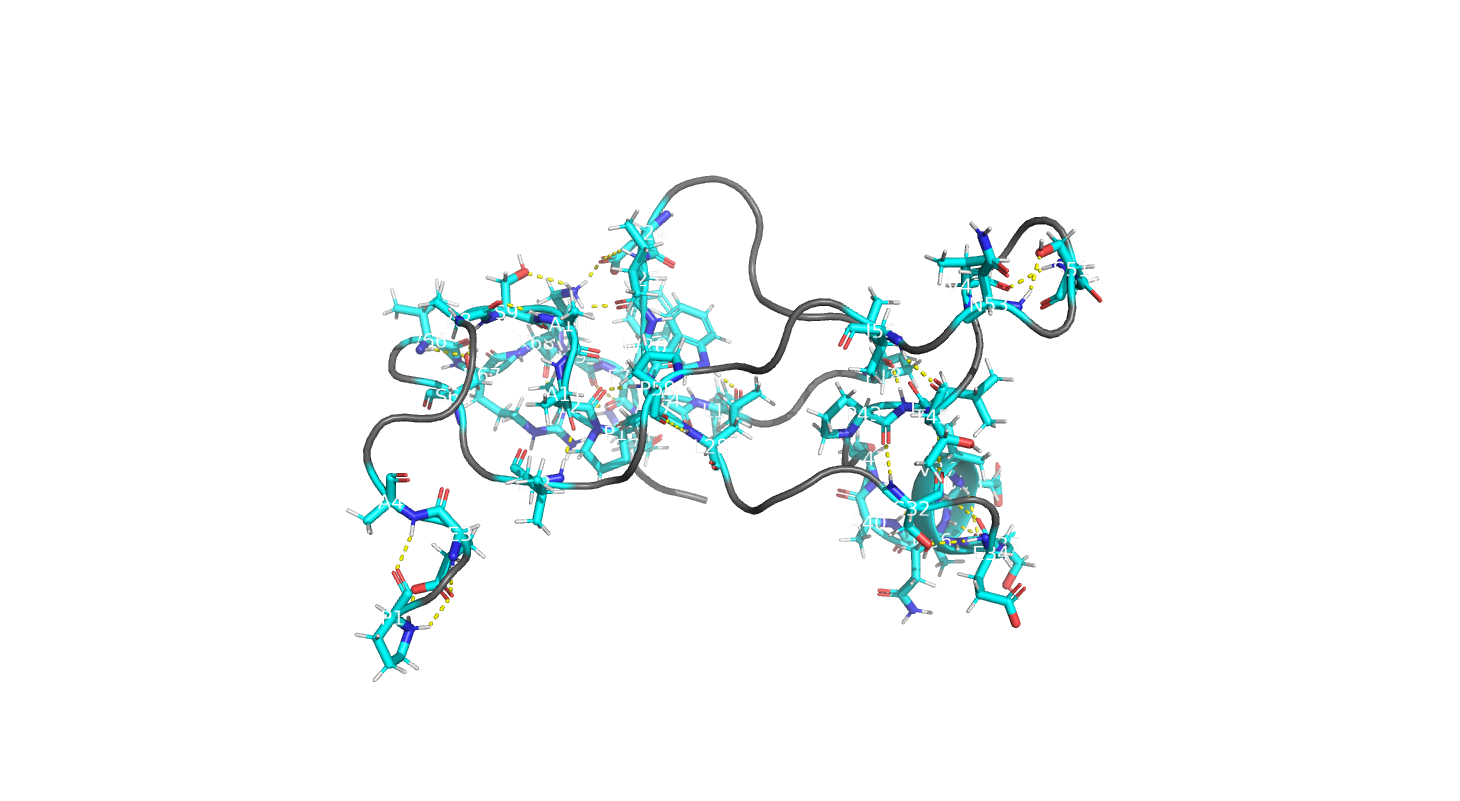

In [1]:
# load python packages
from pymol import cmd
from IPython.display import Image

mol_dyn_id = "JQ679014_hinge_WT_ranked_0_MD-30M"
cmd.do(f"load data/molecular_dynamics/JQ679014_hinge_WT_ranked_0/pdb/{mol_dyn_id}.pse")
path_img = f"/tmp/{mol_dyn_id}.png"
cmd.png(path_img, ray=1)
Image(filename=path_img)

42/73 residues involved in polar contacts at the end of the simulation.

An **Alpha Helix** (more structured) is found from **AA 35 to 39**. 

The PDB file is accessible [here](../molecular_dynamics/JQ679014_hinge_WT_ranked_0/pdb/JQ679014_hinge_WT_ranked_0_MD-30M.pse).

Analysis using the whole protein:
```shell
/data/labo/scripts/molecular_dynamics_trajectories/trajectories.py --topology /data/labo/these/molecular_dynamics/JQ679014_hinge_WT_ranked_0/leap/JQ679014_hinge_WT_ranked_0.parm --output-format png --distance-contacts 3.0 --second-half-percent 20.0 --out /data/labo/these/molecular_dynamics/JQ679014_hinge_WT_ranked_0/trajectory_analysis/whole_protein /data/labo/these/molecular_dynamics/JQ679014_hinge_WT_ranked_0/trajectory_0_to_30M/JQ679014_hinge_WT_ranked_0_MD_0_to_30M.nc
```

Analysis using the selection mask `:35-39` for amino acids of the Alpha Helix only:
```shell
/data/labo/scripts/molecular_dynamics_trajectories/trajectories.py --topology /data/labo/these/molecular_dynamics/JQ679014_hinge_WT_ranked_0/leap/JQ679014_hinge_WT_ranked_0.parm --output-format png --distance-contacts 3.0 --second-half-percent 20.0 --mask :35-39 --out /data/labo/these/molecular_dynamics/JQ679014_hinge_WT_ranked_0/trajectory_analysis/mask_:35-39 /data/labo/these/molecular_dynamics/JQ679014_hinge_WT_ranked_0/trajectory_0_to_30M/JQ679014_hinge_WT_ranked_0_MD_0_to_30M.nc
```

### RMSD

<div style="display: flex; flex-flow: row wrap; text-align: center;">
    <figure style="margin: 5px !important;">
        <img src="data/JQ679014_hinge_WT_ranked_0/trajectory_analysis/whole_protein/RMSD_JQ679014_hinge_WT_ranked_0_MD_0_to_30M.png" style="height: {row_height}">
        <figcaption style="font-size: 0.6em">
            RMSD: Hinge WT whole protein.
        </figcaption>
    </figure>
    <figure style="margin: 5px !important;">
        <img src="data/JQ679014_hinge_WT_ranked_0/trajectory_analysis/mask_:35-39/RMSD_JQ679014_hinge_WT_ranked_0_MD_0_to_30M_:35-39.png" style="height: {row_height}">
        <figcaption style="font-size: 0.6em">
            RMSD: Hinge WT with selection mask from AA 35 to 39.
        </figcaption>
    </figure>
</div>

### Contacts

#### Hinge Wild Type whole protein

The whole Hinge Wild Type whole protein, 81 contacts between ataoms of different residues in the selection mask were detected:

In [2]:
import pandas as pd

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.read_csv("data/JQ679014_hinge_WT_ranked_0/trajectory_analysis/whole_protein/contacts_JQ679014_hinge_WT_ranked_0_MD_0_to_30M.csv")

,contact,mean distance 2nd half,median distance 2nd half,mean distance whole,median distance whole
0,PRO1_O-GLU3_N-H,3.18,3.18,3.31,3.21
1,PRO1_O-ALA4_N-H,2.34,2.29,3.06,2.41
2,PRO2_O-ALA4_N-H,3.12,3.12,3.22,3.18
3,PRO2_O-ALA5_N-H,2.43,2.33,3.33,2.60
4,PRO2_O-ALA6_N-H,2.64,2.29,5.02,5.31
5,GLU3_OE1-PRO1_N-H2,3.00,2.96,5.76,4.02
6,GLU3_OE1-PRO1_N-H3,2.21,2.15,5.79,3.11
7,GLU3_OE2-PRO1_N-H2,3.03,3.02,5.76,4.07
8,GLU3_OE2-PRO1_N-H3,2.20,2.13,5.78,3.20
9,GLU3_OE1-SER64_OG-HG,3.82,3.55,13.72,12.92


![contacts_JQ679014_hinge_WT_ranked_0_MD_0_to_30M](data/JQ679014_hinge_WT_ranked_0/trajectory_analysis/whole_protein/contacts_JQ679014_hinge_WT_ranked_0_MD_0_to_30M.png)

#### Hinge Wild Type AA 35-39

The Hinge Wild Type with selection mask `:35-39`, 4 contacts between atoms of different residues in the selection mask were detected:

In [3]:
pd.read_csv("data/JQ679014_hinge_WT_ranked_0/trajectory_analysis/mask_:35-39/contacts_JQ679014_hinge_WT_ranked_0_MD_0_to_30M.csv")

,contact,mean distance (2nd half),median distance (2nd half),mean distance (whole),median distance (whole)
0,SER1_O-VAL3_N-H,3.10,3.10,3.16,3.13
1,SER1_O-ASP4_N-H,2.42,2.32,4.26,3.33
2,SER1_O-ALA5_N-H,2.50,2.15,4.77,4.78
3,GLN2_O-ALA5_N-H,3.29,3.36,4.68,4.00


![contacts_JQ679014_hinge_WT_ranked_0_MD_0_to_30M_:35-39](data/JQ679014_hinge_WT_ranked_0/trajectory_analysis/mask_:35-39/contacts_JQ679014_hinge_WT_ranked_0_MD_0_to_30M_:35-39.png)

## Hinge with RPS17 insertion (JQ679013)

### RMSD

The Hinge with insertion RPS17 (JQ679013) molecular dynamics 10 million cycles RMSD result: 

![RMSD_JQ679013_hinge_ins-RPS17_ranked_0_MD_0_to_10M](data/JQ679013_hinge_ins-RPS17_ranked_0/cpptraj/RMSD_JQ679013_hinge_ins-RPS17_ranked_0_MD_0_to_10M.png)